In [1]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("processed_spectra.db")  # Replace with your database name

# Specify the table name
table_name = "processed_spectrum"  # Replace with the table you want to inspect

# Fetch column headers
cursor = conn.cursor()
cursor.execute(f"PRAGMA table_info({table_name})")
columns = [col[1] for col in cursor.fetchall()]
print("Column Headers:", columns)

# Fetch and display a sample of the data (first 5 rows)
df = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 5", conn)
print("\nSample Data:")
print(df)

# Close the connection
conn.close()

Column Headers: ['sample_name', 'wavelength', 'intensity', 'depth', 'location', 'location_point']

Sample Data:
  sample_name  wavelength     intensity  depth        location location_point
0          S1   200.01207  0.000000e+00  40-60  Pulo, Seulimum              A
1          S1   200.01207  4.989770e-09  40-60  Pulo, Seulimum              A
2          S1   200.02576  1.102417e-08  40-60  Pulo, Seulimum              A
3          S1   200.02576  1.878044e-08  40-60  Pulo, Seulimum              A
4          S1   200.03944  2.910306e-08  40-60  Pulo, Seulimum              A


In [8]:
import sqlite3

# Connect to your SQLite database
conn = sqlite3.connect("kopi2.db")  # Replace with the path to your database file

# Query to get all table names
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print out all table names
print("Tables in the database:")
for table in tables:
    print(table[0])

# Close the connection
conn.close()

Tables in the database:
spectrum_data
sqlite_sequence


In [12]:
import pandas as pd
import sqlite3

# Load CSV file without headers
file_path = "Kopi.csv"  # Replace with your CSV file path
df = pd.read_csv(file_path, header=None)

# Define column names: "Wavelength" and "S1" to "S13"
df.columns = ["Wavelength"] + [f"S{i}" for i in range(1, 14)]

# Reshape the DataFrame so each sample has its own row with a key
reshaped_data = pd.DataFrame()
for i, col in enumerate(df.columns[1:], start=1):
    temp_df = df[["Wavelength", col]].copy()
    temp_df.columns = ["Wavelength", "Intensity"]
    temp_df["sample_name"] = f"S{i}"
    reshaped_data = pd.concat([reshaped_data, temp_df], ignore_index=True)

# Connect to SQLite database and save reshaped data with Sample as key
conn = sqlite3.connect("app2/processed_spectra1.db")  # Replace with desired database name
reshaped_data.to_sql("processed_spectrum", conn, if_exists="replace", index=False)

# Close the connection
conn.close()

In [5]:
import sqlite3
import pandas as pd

def export_to_ascii_format_with_offset(db_path, sample_name, output_file):
    # Koneksi ke database
    conn = sqlite3.connect(db_path)
    
    # Query untuk memilih data sesuai sample_name yang diinginkan
    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ?
        ORDER BY wavelength
    """
    
    # Membaca data ke dalam DataFrame
    df = pd.read_sql_query(query, conn, params=(sample_name,))
    
    # Menambahkan offset ke intensitas
    df['intensity'] += 0.00000001
    
    # Menutup koneksi
    conn.close()
    
    # Mengekspor ke file ASCII dengan delimitasi spasi tanpa header
    with open(output_file, 'w') as f:
        for index, row in df.iterrows():
            # Format ke dua kolom dengan spasi sebagai pemisah
            f.write(f"{row['wavelength']} {row['intensity']}\n")
    
    print(f"Data untuk sample {sample_name} berhasil diekspor ke {output_file} dalam format ASCII.")

# Penggunaan fungsi
db_path = 'processed_spectra.db'  # Path ke database
sample_name = 'S1'               # Nama sampel yang ingin diekspor
output_file = f'{sample_name}.asc'  # Nama file keluaran

export_to_ascii_format_with_offset(db_path, sample_name, output_file)

Data untuk sample S1 berhasil diekspor ke S1.asc dalam format ASCII.


2024-11-06 17:06:49.344 Python[22515:1010325] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-06 17:06:49.344 Python[22515:1010325] +[IMKInputSession subclass]: chose IMKInputSession_Modern


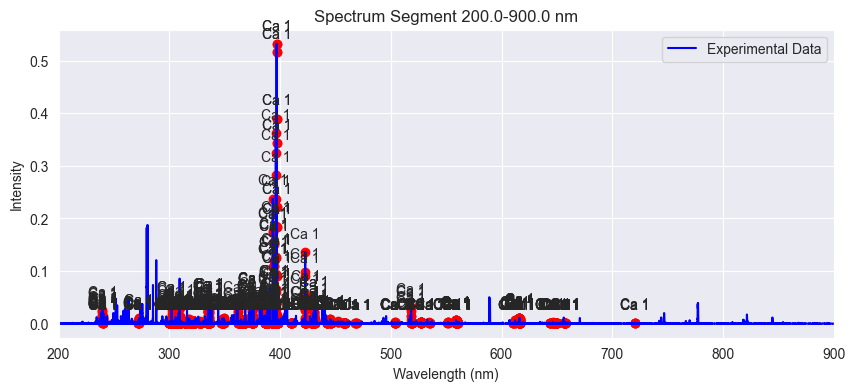

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tkinter import Tk, Button, Label, Entry, Frame, Scrollbar, RIGHT, Y, StringVar, OptionMenu
from tkinter.ttk import Treeview
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Function to get experimental spectra within the range 200-900 nm
def get_experimental_spectra_200_900(db_path, sample_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ? AND wavelength BETWEEN 200 AND 900
        ORDER BY wavelength
    """
    cursor.execute(query, (sample_name,))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths, dtype=float)
    intensities = np.array(intensities, dtype=float)
    return np.array(wavelengths), np.array(intensities)

# Function to get all NIST data matching a specific element and ion stage
def get_nist_data_for_element_and_sp_num(db_nist, element, sp_num):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    query = """
        SELECT "obs_wl_air(nm)", element, sp_num, "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "acc"
        FROM spectrum_data
        WHERE element = ? AND sp_num = ?
    """
    cursor.execute(query, (element, sp_num))
    nist_lines = cursor.fetchall()
    conn.close()

    return nist_lines

def save_to_excel():
    selected_items = tree.selection()
    selected_data = []
    
    for item in selected_items:
        selected_data.append(tree.item(item, "values"))

    if not selected_data:
        print("No data selected for saving.")
        return

    new_df = pd.DataFrame(selected_data, columns=[
        "Wavelength NIST", "Element", "Ion Stage", 
        "Experimental Wavelength", "Intensity", 
        "gA", "Ek", "Ei", "Accuracy"
    ])

    sample_name = sample_var.get()
    file_path = f"{sample_name}.xlsx"
    
    try:
        existing_df = pd.read_excel(file_path)
        updated_df = pd.concat([existing_df, new_df], ignore_index=True).drop_duplicates()
    except FileNotFoundError:
        updated_df = new_df
    
    updated_df.to_excel(file_path, index=False)
    print("Data has been updated in", file_path)
# Function to match NIST data with experimental spectra and filter by intensity threshold
def match_nist_with_experimental(wavelengths, intensities, nist_data, lower, upper, intensity_lower, intensity_upper):
    matched_data = []
    mask = (wavelengths >= lower) & (wavelengths < upper)
    wl_segment = wavelengths[mask]
    intensity_segment = np.array(intensities[mask], dtype=float)

    if len(wl_segment) == 0 or len(intensity_segment) == 0:
        return matched_data

    peaks, _ = find_peaks(intensity_segment)
    peaks_wavelengths = wl_segment[peaks]

    for wl_nist, element, sp_num, gA, Ek, Ei, acc in nist_data:
        if acc is not None:
            wl_nist = float(wl_nist)
            if lower <= wl_nist < upper:
                match_indices = np.where(np.abs(peaks_wavelengths - wl_nist) < 0.6)[0]
                for idx in match_indices:
                    wl_exp = peaks_wavelengths[idx]
                    intensity_exp = intensity_segment[peaks[idx]]
                    # Filter based on intensity range
                    if intensity_lower <= intensity_exp <= intensity_upper:
                        matched_data.append({
                            "Wavelength NIST": wl_nist,
                            "Element": element,
                            "Ion Stage": sp_num,
                            "Experimental Wavelength": wl_exp,
                            "Intensity": intensity_exp,
                            "gA": gA,
                            "Ek": Ek,
                            "Ei": Ei,
                            "Accuracy": acc
                        })

    matched_data.sort(key=lambda x: x["Intensity"], reverse=True)
    return matched_data

# Function to display results in table
def display_results_in_table(matched_data):
    tree.delete(*tree.get_children())
    for i, row in enumerate(matched_data):
        tree.insert("", "end", iid=i, values=(
            row["Wavelength NIST"], row["Element"], row["Ion Stage"], 
            row["Experimental Wavelength"], row["Intensity"], 
            row["gA"], row["Ek"], row["Ei"], row["Accuracy"]
        ))

# Function to plot selected segment
def plot_selected_segment(wavelengths, intensities, nist_data, lower, upper, intensity_lower, intensity_upper):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_xlim(lower, upper)
    ax.set_title(f"Spectrum Segment {lower}-{upper} nm")

    mask = (wavelengths >= lower) & (wavelengths < upper)
    wl_segment = wavelengths[mask]
    intensity_segment = intensities[mask]

    if len(wl_segment) == 0 or len(intensity_segment) == 0:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12, color='gray')
    else:
        ax.plot(wl_segment, intensity_segment, label='Experimental Data', color='blue')
        peaks, _ = find_peaks(intensity_segment)
        peaks_wavelengths = wl_segment[peaks]

        for wl_nist, element, sp_num, gA, Ek, Ei, acc in nist_data:
            wl_nist = float(wl_nist)
            if lower <= wl_nist < upper:
                match_indices = np.where(np.abs(peaks_wavelengths - wl_nist) < 0.6)[0]
                for idx in match_indices:
                    wl_exp = peaks_wavelengths[idx]
                    intensity_exp = intensity_segment[peaks[idx]]
                    # Filter based on intensity range
                    if intensity_lower <= intensity_exp <= intensity_upper:
                        ax.scatter(wl_exp, intensity_exp, color='red')
                        ax.annotate(f"{element} {sp_num}", (wl_exp, intensity_exp), textcoords="offset points", xytext=(0,10), ha='center')

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Intensity')
    ax.grid(True)
    ax.legend(loc="upper right")

    for widget in plot_frame.winfo_children():
        widget.destroy()
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()

# Event handler for selecting segment
def on_segment_selected(event=None):
    try:
        lower = float(lower_bound_entry.get())
        upper = float(upper_bound_entry.get())
        intensity_lower = float(intensity_lower_entry.get())
        intensity_upper = float(intensity_upper_entry.get())
    except ValueError:
        print("Please enter valid numerical values for bounds and intensity range.")
        return

    element = element_entry.get().strip()
    sp_num = int(ion_stage_var.get())
    sample_name = sample_var.get()

    wavelengths, intensities = get_experimental_spectra_200_900(db_path, sample_name)
    nist_data = get_nist_data_for_element_and_sp_num(db_nist, element, sp_num)
    matched_data = match_nist_with_experimental(wavelengths, intensities, nist_data, lower, upper, intensity_lower, intensity_upper)
    display_results_in_table(matched_data)
    plot_selected_segment(wavelengths, intensities, nist_data, lower, upper, intensity_lower, intensity_upper)

# Database configuration
db_path = 'processed_spectra.db'
db_nist = 'data1.db'

# GUI setup
root = Tk()
root.title("Spectrum Analyzer")

# Left Frame for input fields
input_frame = Frame(root)
input_frame.pack(side="left", padx=10, pady=10)

# Sample selection input
Label(input_frame, text="Select Sample:").pack()
sample_var = StringVar(root)
sample_var.set("S1")
sample_menu = OptionMenu(input_frame, sample_var, *[f"S{i}" for i in range(1, 25)])
sample_menu.pack()

# Element input with Entry
Label(input_frame, text="Enter Element:").pack()
element_entry = Entry(input_frame)
element_entry.pack()

# Ion stage selection
Label(input_frame, text="Select Ion Stage:").pack()
ion_stage_var = StringVar(root)
ion_stage_var.set("1")
ion_stage_menu = OptionMenu(input_frame, ion_stage_var, "1", "2", "3", "4", "5")
ion_stage_menu.pack()

# Intensity threshold range input (Lower and Upper bounds)
Label(input_frame, text="Intensity Lower Bound:").pack()
intensity_lower_entry = Entry(input_frame)
intensity_lower_entry.insert(0, "0.001")
intensity_lower_entry.pack()

Label(input_frame, text="Intensity Upper Bound:").pack()
intensity_upper_entry = Entry(input_frame)
intensity_upper_entry.insert(0, "1.0")  # Default upper bound for intensity
intensity_upper_entry.pack()

# Wavelength range input (Lower and Upper bounds)
Label(input_frame, text="Lower Bound (nm):").pack()
lower_bound_entry = Entry(input_frame)
lower_bound_entry.insert(0, "200")
lower_bound_entry.pack()

Label(input_frame, text="Upper Bound (nm):").pack()
upper_bound_entry = Entry(input_frame)
upper_bound_entry.insert(0, "900")
upper_bound_entry.pack()

# Analyze button
analyze_button = Button(input_frame, text="Analyze Segment", command=on_segment_selected)
analyze_button.pack(pady=10)
save_button = Button(input_frame, text="Save to Excel", command=save_to_excel)
save_button.pack(pady=10)

# Right Frame for table and plot
display_frame = Frame(root)
display_frame.pack(side="right", padx=10, pady=10)

# Table frame and scrollbar in display_frame
frame = Frame(display_frame)
frame.pack(pady=10)

# Treeview table setup
columns = ["Wavelength NIST", "Element", "Ion Stage", "Experimental Wavelength",
           "Intensity", "gA", "Ek", "Ei", "Accuracy"]
tree = Treeview(frame, columns=columns, show="headings", selectmode="extended")
for col in columns:
    tree.heading(col, text=col)
    tree.column(col, width=100)

scrollbar = Scrollbar(frame, orient="vertical", command=tree.yview)
tree.configure(yscrollcommand=scrollbar.set)
scrollbar.pack(side=RIGHT, fill=Y)
tree.pack()

# Plot frame in display_frame
plot_frame = Frame(display_frame)
plot_frame.pack(pady=10)

# Run GUI
root.mainloop()